# List 3 US analysis of tweets during US election

Authors: Kacper Grzelak and Maciej Ulewski

In [109]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import tweepy as tw
import json
from pandas import DataFrame
import plotly
import collections
import re
import itertools
from textblob import TextBlob
import datetime
import seaborn as sns
import numpy as np

## Downloading tweets.
First of all, each of us has to create for himself tweeter developer account. After getting the permission with consumer keys and access token we could use the teepy library to download the data.

The algorithm is quite simple, we are trying to get every tweet with several hashtags in four main cities in US.
The hashtags are: #GE2020, #GE20, #GeneralElection, #GeneralElection2020 and #Election2020. We do not take retweets, but only the original ones. We have searched for our answer in 4 cities, which are: New York, Los Angeles, Houston and Washington. Why these places, not the other ones? The answer is also simple, we took 2 cities where Joe Biden has won and 2 where majority of vote was for Donald Trump.

We took a period which is one week from 29th of October to 5th of November. The election day was 3rd of November so in the middle of this period. After downloading 250 tweets per day from each city we created .json files.

In [7]:
# consumer_key= '' #We should not share our privacy keys and tokens so it is empty
# consumer_secret= ''
# access_token= ''
# access_token_secret= ''


auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)


In [50]:
date_since = "2020-10-20"
q ="#GE2020 OR #GE20 OR #GeneralElection OR #GeneralElection2020 OR #Election2020 -filter:retweets"

NY = "40.714353,-74.00597299999998,100km" #Four main cities in witch we will be shearch the tweets
LA = "34.0207289,-118.6926019,100km"
Houston = "29.7632800,-95.3632700,23km"
WA = "38.8972578,-77.0345083,100km"


US = [NY,LA,Houston,WA]
place_name = ['NY','LA','Houston','WA']
#Vector which help us to take tweets form exact days
date = ["2020-10-29","2020-10-30","2020-10-31","2020-11-01",
        "2020-11-02","2020-11-03","2020-11-04","2020-11-05","2020-11-06"] 
#Here is the main loop where we are taking 250 tweets from each city and for exact day.
for k in range(0,len(US)):
    tweet_list = []
    for i in range(0,8):
        tweets = tw.Cursor(api.search, q, geocode=US[k],lang="en",since=date[i],until=date[i+1]).items(250)
        for tweet in tweets:
                 tweet_list.append(tweet._json)
    file = open(f'{place_name[k]}.json', 'wb')
    #Here we are saving tweets to the .json files with names of the cities
    print(f"Writing tweet objects to JSON from {place_name[k]} please wait...")   
    with open(f'Twitter_data/{place_name[k]}.json', 'w', encoding='utf8') as file:
        json.dump(tweet_list,file)

Writing tweet objects to JSON from NY please wait...
Writing tweet objects to JSON from LA please wait...
Writing tweet objects to JSON from Houston please wait...
Writing tweet objects to JSON from WA please wait...


## Analyzing the data.
Using pandas and json library’s we created data frames for each city and insert into them several columns with data from .json files. <br>
Overview of data frames:
<br>**User** - name of the twitter's account
<br>**Date of creation** - when post was created
<br>**Numbers of retweets** - amount of retweets
<br>**City** - name of the city
<br>**Text** - tweet's text 
<br>**Hashtags** - hashtags used in the post
<br>**Likes** - number of positives reactions on this tweet

In [74]:
with open("Twitter_data/NY.json") as json_file:
    data_ny = json.load(json_file)
with open("Twitter_data/LA.json") as json_file:
    data_la = json.load(json_file)
with open("Twitter_data/Houston.json") as json_file:
    data_ho = json.load(json_file)
with open("Twitter_data/WA.json") as json_file:
    data_wa = json.load(json_file)
    
data = [data_ny,data_la,data_ho,data_wa]


df_list = []


for k in range(0,4):
    town = data[k]
    city = []
    text = []
    user = []
    created = []
    favorite = []
    retweet = []
    hashtags = []
    sentiments = []
    for tweet in town:
        created.append(tweet['created_at']) #Creation columns
        favorite.append(tweet['favorite_count'])
        retweet.append(tweet['retweet_count'])
        city.append(tweet['user']['location'])
        text.append(tweet['text'])
        user.append(tweet['user']['name'])  
        hstg=tweet['entities']['hashtags']
        if hstg!=[]:
            hashtags.append(hstg[0]['text'])
        else:
            hashtags.append('')
        sentiments.append(TextBlob(tweet['text']).polarity)
    df_list.append(pd.DataFrame(list(zip(user,created,retweet, city, text,hashtags,sentiments,favorite)),columns=['User','Date of creation','Numbers of retweets','City','Text','Hashtags','Polarity','Likes']))  

    
    
df_ny = DataFrame(df_list[0]) #data for New York
df_la = DataFrame(df_list[1]) #data for Los Angeles
df_ho = DataFrame(df_list[2]) #data for Houston
df_wo = DataFrame(df_list[3]) #data for Woshington DC

df_ny['Date of creation'] = pd.to_datetime(df_ny['Date of creation']) #Changing type 'Date of creation' column as datetime
df_la['Date of creation'] = pd.to_datetime(df_la['Date of creation']) 
df_ho['Date of creation'] = pd.to_datetime(df_ho['Date of creation']) 
df_wo['Date of creation'] = pd.to_datetime(df_wo['Date of creation']) 

## New functions
We have created several functions to create our code easier to understand and a liitle cleaner.

In [75]:
def remove_url(txt): # This function is removing url from text
    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())

def remove_stopwords(params): # This function is removing polish stopwords from text
    with open("Twitter_data/stopwords_tweeter.txt",'r') as my_stopwords:
        stopwords_list = my_stopwords.read()
        new_list = []
        for param in params:
            if str(param) not in stopwords_list:
                new_list.append(param)
            else:
                pass
    my_stopwords.close()
    return new_list
    
def count_most_common(dataframe,stopwords,N=15): #This function is counting most comon words in text
    tw_txt=dataframe['Text'].tolist()
    if stopwords == 1:
        tw_txt=dataframe['Text'].tolist()
        tw_clean=[remove_url(tweet) for tweet in tw_txt]
        words=[tweet.lower().split() for tweet in tw_clean]
        all_words=list(itertools.chain(*words))
        all_words = remove_stopwords(all_words)
        counts=collections.Counter(all_words)
        return counts.most_common(N)
    else:
        tw_clean=[remove_url(tweet) for tweet in tw_txt]
        words=[tweet.lower().split() for tweet in tw_clean]
        all_words=list(itertools.chain(*words))
        counts=collections.Counter(all_words)
        return counts.most_common(N)
def clean_datatime(dataframe,since = datetime.date(2020,10,29)): #This function is cleaning dataframe with already downloaded tweets
    dataframe['Date of creation'] = pd.to_datetime(dataframe['Date of creation']) #Changing type 'Date of creation' column as datetime
    dataframe['Just date'] = dataframe['Date of creation'].dt.date #Adding column with data and time of the tweet
    dataframe['Just time'] = dataframe['Date of creation'].dt.time
    dataframe = dataframe[dataframe['Just date']>= since]
    return dataframe

In [76]:
df_ny.head(10)

,User,Date of creation,Numbers of retweets,City,Text,Hashtags,Polarity,Likes
0,Jay,2020-10-29 23:55:22+00:00,0,The Backyard,The election is right around the corner and to...,,0.285714,0
1,POPDUST,2020-10-29 23:52:16+00:00,0,NYC,@shaedband with a special video encouraging al...,GetOutTheVote,0.446429,1
2,Empire State Conservatives,2020-10-29 23:48:31+00:00,0,"New York, USA",The Urban Conservative Pre-Election Day Show p...,election2020,0.000000,0
3,Deborah O'Donnell,2020-10-29 23:48:18+00:00,0,"Beacon, NY",#Vote New Yorkers. Take your absentee ballot t...,Vote,0.136364,1
4,translashmedia,2020-10-29 23:43:52+00:00,0,"New York, USA","""People may protest the counting of votes in y...",,0.000000,0
5,민권센터 #NoRezoning #CancelRent,2020-10-29 23:42:59+00:00,7,"Flushing, NY",.@BOENYC has expanded Early Voting Hours! Poll...,,0.025000,9
6,translashmedia,2020-10-29 23:40:43+00:00,0,"New York, USA","""It doesn't stop at the Supreme Court. Local a...",,0.200000,1
7,translashmedia,2020-10-29 23:38:24+00:00,1,"New York, USA","""If the Supreme Court strikes down the Afforda...",,-0.234028,3
8,Jamjum A Majeed,2020-10-29 23:36:59+00:00,0,"Bridgeport, CT",Last weekend before elections. #Election2020 ...,Election2020,0.000000,0
9,Bryan (he/him) 🇵🇭🇺🇸 #Election2020 🗳️,2020-10-29 23:33:11+00:00,1,"Mount Vernon, NY",This is part of our new series exploring elect...,,0.136364,1


In [77]:
df_la.head(10)

,User,Date of creation,Numbers of retweets,City,Text,Hashtags,Polarity,Likes
0,D. Leigh Writes,2020-10-29 23:55:23+00:00,0,Los Angeles,Oooooooo. So busted. #Receipts #VoteBollier #V...,Receipts,0.000000,1
1,Madam Jaz'min,2020-10-29 23:54:43+00:00,0,"Los Angeles, CA",Funny how you are losing in the polls in #Minn...,Minnesota,0.250000,0
2,Neal Broverman,2020-10-29 23:50:09+00:00,0,Los Angeles,Pathological lying. #Election2020 https://t.co...,Election2020,0.000000,4
3,Madeline Elizabeth,2020-10-29 23:49:00+00:00,0,"Los Angeles, CA","Look at the communities and crowds, research t...",,0.000000,0
4,Savory Prime,2020-10-29 23:48:52+00:00,0,"Oxnard, Ca","Friendly reminder, Election Day is coming. Nov...",Election2020,0.291667,0
5,Tami Stroud,2020-10-29 23:47:10+00:00,0,"Orange County, CA",Mask up and take your ballot to an Official dr...,vote,0.000000,0
6,"J. ""Affirmative Action Hack"" Perkins 😷",2020-10-29 23:38:28+00:00,0,"Philadelphia, PA",New collection of #Election2020 resources from...,Election2020,0.136364,0
7,Ernesto Arce,2020-10-29 23:38:27+00:00,0,"Los Angeles, CA",I'm not trying to discourage voting because th...,,0.300000,0
8,Marcus F Benigno,2020-10-29 23:37:51+00:00,0,"Los Angeles, CA • he/him/his",Don’t get it twisted. #Election2020 https://t....,Election2020,-0.500000,4
9,TheAtlasPost,2020-10-29 23:36:36+00:00,0,Los Angeles,How to Track Your Ballot – State by State http...,Election2020,0.000000,0


In [78]:
df_ho.head(10)

,User,Date of creation,Numbers of retweets,City,Text,Hashtags,Polarity,Likes
0,Mark V,2020-10-29 23:01:31+00:00,0,"HTown, Texas USA",@notannieok if you haven’t seen this https://...,Election2020,0.000000,1
1,Theodore R. Smith,2020-10-29 22:47:40+00:00,0,"Houston, TX",Would someone please tell me 1 positive goal o...,Election2020,0.263636,0
2,Houston Chronicle,2020-10-29 20:29:03+00:00,5,"Houston, TX",Are you planning some late-night voting tonigh...,,0.000000,9
3,D Kurian,2020-10-29 20:23:03+00:00,0,"Houston, TX","Lies, Lies, Lies, and then Statistics (Polls)....",Opinion,0.000000,0
4,Pooja Lodhia,2020-10-29 19:54:44+00:00,1,"Houston, TX",Haven’t voted yet? Guess what?! Voting cente...,,0.000000,7
5,Holly Hansen,2020-10-29 19:43:17+00:00,7,"Houston, Texas",Inbox: #Texas Senator @TeamBettencourt notes #...,Texas,0.050000,13
6,Charles Adams,2020-10-29 19:06:25+00:00,0,"Houston, TX",My thoughts on this election. #Election2020 ht...,Election2020,0.000000,11
7,One Breath Partnership,2020-10-29 19:04:10+00:00,0,"Houston, TX","As @cathwfraser writes, “Democracy happens eve...",Election2020,-0.071429,6
8,One Breath Partnership,2020-10-29 19:04:02+00:00,5,"Houston, TX",Our newsletter went out today!\n\nIt begins an...,,0.136364,10
9,UTHealth,2020-10-29 18:55:05+00:00,2,"Houston, TX",Is the upcoming election stressing you out? Bo...,,0.000000,0


In [79]:
df_wo.head(10)

,User,Date of creation,Numbers of retweets,City,Text,Hashtags,Polarity,Likes
0,Zee Shaw,2020-10-29 23:59:11+00:00,0,"Washington, DC",President Trump can steal this election by ral...,,0.00,0
1,Mike Blaiz,2020-10-29 23:56:15+00:00,0,"California, USA",@realDonaldTrump #dances to #thriller by #mich...,dances,0.00,3
2,Cheryl Prevor Psy.D🔥,2020-10-29 23:54:45+00:00,0,California....,"So let me get this straight, trump’s incompete...",Election2020,0.00,0
3,Ron Trumbo,2020-10-29 23:53:54+00:00,0,"California, USA",@Mike_Pence You had 4 years and you have made ...,Election2020,-0.40,0
4,Absolut.LIBRA,2020-10-29 23:53:48+00:00,0,"Washington, DC",5 states at high risk for armed militia group ...,election2020,0.16,2
5,Diana L Guerrero,2020-10-29 23:53:41+00:00,0,"California, USA",#Vote2020 get out and #rockthevote \n.\n.\n.\n...,Vote2020,0.00,0
6,Ada Orie,2020-10-29 23:53:12+00:00,0,"Baltimore, Maryland","""I casted my vote on election day in person be...",,0.05,0
7,AP Politics,2020-10-29 23:51:40+00:00,3,"Washington, D.C.",THREAD: Here’s what’s happening today in #Elec...,Election2020,0.35,9
8,Mike Blaiz,2020-10-29 23:48:27+00:00,1,"California, USA",Keep on #rocking in the #freeworld #vote #trum...,rocking,0.00,3
9,Twinkledick,2020-10-29 23:46:25+00:00,0,Everywheresville,#election2020 #lilwayne @ Washington D.C. http...,election2020,0.00,0


## Cleaning data
According to the content of the first task, we assumed that tweets downloaded from specific locations actually belong to these cities or states. In the following section, we remove all inconsistent data in each table so that all the locations match.

In [80]:
city1 = []
city = []
state = []
city1 = df_ny['City']
for i in city1:
    separated = i.split(',')#Split the coord atribute with name of the city and state
    if len(separated) == 1:
        city.append(separated[0].capitalize())
        state.append('NY')
    elif len(separated) == 2:
        city.append(separated[0].capitalize())
        if separated[1] == 'NY':
            state.append(separated[1])
        else:
            state.append('NY')
df_ny['State'] = pd.Series(state)
df_ny.drop(["City"], axis = 1, inplace = True)
### DO NOT RUN THIS CODE 2 TIMES IN A ROW, 
###IF YOU WANT TO RUN IT AGAIN, YOU WILL HAVE TO DECLARE THE DF AGAIN.
df_ny['City'] = pd.Series(city)
df_ny.head(10)

,User,Date of creation,Numbers of retweets,Text,Hashtags,Polarity,Likes,State,City
0,Jay,2020-10-29 23:55:22+00:00,0,The election is right around the corner and to...,,0.285714,0,NY,The backyard
1,POPDUST,2020-10-29 23:52:16+00:00,0,@shaedband with a special video encouraging al...,GetOutTheVote,0.446429,1,NY,Nyc
2,Empire State Conservatives,2020-10-29 23:48:31+00:00,0,The Urban Conservative Pre-Election Day Show p...,election2020,0.000000,0,NY,New york
3,Deborah O'Donnell,2020-10-29 23:48:18+00:00,0,#Vote New Yorkers. Take your absentee ballot t...,Vote,0.136364,1,NY,Beacon
4,translashmedia,2020-10-29 23:43:52+00:00,0,"""People may protest the counting of votes in y...",,0.000000,0,NY,New york
5,민권센터 #NoRezoning #CancelRent,2020-10-29 23:42:59+00:00,7,.@BOENYC has expanded Early Voting Hours! Poll...,,0.025000,9,NY,Flushing
6,translashmedia,2020-10-29 23:40:43+00:00,0,"""It doesn't stop at the Supreme Court. Local a...",,0.200000,1,NY,New york
7,translashmedia,2020-10-29 23:38:24+00:00,1,"""If the Supreme Court strikes down the Afforda...",,-0.234028,3,NY,New york
8,Jamjum A Majeed,2020-10-29 23:36:59+00:00,0,Last weekend before elections. #Election2020 ...,Election2020,0.000000,0,NY,Bridgeport
9,Bryan (he/him) 🇵🇭🇺🇸 #Election2020 🗳️,2020-10-29 23:33:11+00:00,1,This is part of our new series exploring elect...,,0.136364,1,NY,Mount vernon


In [81]:
city1 = []
city = []
state = []
city1 = df_la['City']
for i in city1:
    separated = i.split(',')
    if len(separated) == 1:
        city.append(separated[0].capitalize())
        state.append('CA')
    elif len(separated) == 2:
        city.append(separated[0].capitalize())
        if separated[1] == 'CA':
            state.append(separated[1])
        else:
            state.append('CA')
df_la['State'] = pd.Series(state)
df_la.drop(["City"], axis = 1, inplace = True)
### DO NOT RUN THIS CODE 2 TIMES IN A ROW, 
###IF YOU WANT TO RUN IT AGAIN, YOU WILL HAVE TO DECLARE THE DF AGAIN.
df_la['City'] = pd.Series(city)
df_la.head(10)

,User,Date of creation,Numbers of retweets,Text,Hashtags,Polarity,Likes,State,City
0,D. Leigh Writes,2020-10-29 23:55:23+00:00,0,Oooooooo. So busted. #Receipts #VoteBollier #V...,Receipts,0.000000,1,CA,Los angeles
1,Madam Jaz'min,2020-10-29 23:54:43+00:00,0,Funny how you are losing in the polls in #Minn...,Minnesota,0.250000,0,CA,Los angeles
2,Neal Broverman,2020-10-29 23:50:09+00:00,0,Pathological lying. #Election2020 https://t.co...,Election2020,0.000000,4,CA,Los angeles
3,Madeline Elizabeth,2020-10-29 23:49:00+00:00,0,"Look at the communities and crowds, research t...",,0.000000,0,CA,Los angeles
4,Savory Prime,2020-10-29 23:48:52+00:00,0,"Friendly reminder, Election Day is coming. Nov...",Election2020,0.291667,0,CA,Oxnard
5,Tami Stroud,2020-10-29 23:47:10+00:00,0,Mask up and take your ballot to an Official dr...,vote,0.000000,0,CA,Orange county
6,"J. ""Affirmative Action Hack"" Perkins 😷",2020-10-29 23:38:28+00:00,0,New collection of #Election2020 resources from...,Election2020,0.136364,0,CA,Philadelphia
7,Ernesto Arce,2020-10-29 23:38:27+00:00,0,I'm not trying to discourage voting because th...,,0.300000,0,CA,Los angeles
8,Marcus F Benigno,2020-10-29 23:37:51+00:00,0,Don’t get it twisted. #Election2020 https://t....,Election2020,-0.500000,4,CA,Los angeles
9,TheAtlasPost,2020-10-29 23:36:36+00:00,0,How to Track Your Ballot – State by State http...,Election2020,0.000000,0,CA,Los angeles


In [82]:
city1 = []
city = []
state = []
city1 = df_ho['City']
for i in city1:
    separated = i.split(',')
    if len(separated) == 1:
        city.append(separated[0].capitalize())
        state.append('TX')
    elif len(separated) == 2:
        city.append(separated[0].capitalize())
        if separated[1] == 'TX':
            state.append(separated[1])
        else:
            state.append('TX')
df_ho['State'] = pd.Series(state)
df_ho.drop(["City"], axis = 1, inplace = True)
### DO NOT RUN THIS CODE 2 TIMES IN A ROW, 
###IF YOU WANT TO RUN IT AGAIN, YOU WILL HAVE TO DECLARE THE DF AGAIN.
df_ho['City'] = pd.Series(city)
df_ho.head(10)

,User,Date of creation,Numbers of retweets,Text,Hashtags,Polarity,Likes,State,City
0,Mark V,2020-10-29 23:01:31+00:00,0,@notannieok if you haven’t seen this https://...,Election2020,0.000000,1,TX,Htown
1,Theodore R. Smith,2020-10-29 22:47:40+00:00,0,Would someone please tell me 1 positive goal o...,Election2020,0.263636,0,TX,Houston
2,Houston Chronicle,2020-10-29 20:29:03+00:00,5,Are you planning some late-night voting tonigh...,,0.000000,9,TX,Houston
3,D Kurian,2020-10-29 20:23:03+00:00,0,"Lies, Lies, Lies, and then Statistics (Polls)....",Opinion,0.000000,0,TX,Houston
4,Pooja Lodhia,2020-10-29 19:54:44+00:00,1,Haven’t voted yet? Guess what?! Voting cente...,,0.000000,7,TX,Houston
5,Holly Hansen,2020-10-29 19:43:17+00:00,7,Inbox: #Texas Senator @TeamBettencourt notes #...,Texas,0.050000,13,TX,Houston
6,Charles Adams,2020-10-29 19:06:25+00:00,0,My thoughts on this election. #Election2020 ht...,Election2020,0.000000,11,TX,Houston
7,One Breath Partnership,2020-10-29 19:04:10+00:00,0,"As @cathwfraser writes, “Democracy happens eve...",Election2020,-0.071429,6,TX,Houston
8,One Breath Partnership,2020-10-29 19:04:02+00:00,5,Our newsletter went out today!\n\nIt begins an...,,0.136364,10,TX,Houston
9,UTHealth,2020-10-29 18:55:05+00:00,2,Is the upcoming election stressing you out? Bo...,,0.000000,0,TX,Houston


In [83]:
city1 = []
city = []
state = []
city1 = df_wo['City']
for i in city1:
    separated = i.split(',')
    if len(separated) == 1:
        city.append(separated[0].capitalize())
        state.append('SC')
    elif len(separated) == 2:
        city.append(separated[0].capitalize())
        if separated[1] == 'SC':
            state.append(separated[1])
        else:
            state.append('SC')
df_wo['State'] = pd.Series(state)
df_wo.drop(["City"], axis = 1, inplace = True)
### DO NOT RUN THIS CODE 2 TIMES IN A ROW, 
###IF YOU WANT TO RUN IT AGAIN, YOU WILL HAVE TO DECLARE THE DF AGAIN.
df_wo['City'] = pd.Series(city)
df_wo.head(10)

,User,Date of creation,Numbers of retweets,Text,Hashtags,Polarity,Likes,State,City
0,Zee Shaw,2020-10-29 23:59:11+00:00,0,President Trump can steal this election by ral...,,0.00,0,SC,Washington
1,Mike Blaiz,2020-10-29 23:56:15+00:00,0,@realDonaldTrump #dances to #thriller by #mich...,dances,0.00,3,SC,California
2,Cheryl Prevor Psy.D🔥,2020-10-29 23:54:45+00:00,0,"So let me get this straight, trump’s incompete...",Election2020,0.00,0,SC,California....
3,Ron Trumbo,2020-10-29 23:53:54+00:00,0,@Mike_Pence You had 4 years and you have made ...,Election2020,-0.40,0,SC,California
4,Absolut.LIBRA,2020-10-29 23:53:48+00:00,0,5 states at high risk for armed militia group ...,election2020,0.16,2,SC,Washington
5,Diana L Guerrero,2020-10-29 23:53:41+00:00,0,#Vote2020 get out and #rockthevote \n.\n.\n.\n...,Vote2020,0.00,0,SC,California
6,Ada Orie,2020-10-29 23:53:12+00:00,0,"""I casted my vote on election day in person be...",,0.05,0,SC,Baltimore
7,AP Politics,2020-10-29 23:51:40+00:00,3,THREAD: Here’s what’s happening today in #Elec...,Election2020,0.35,9,SC,Washington
8,Mike Blaiz,2020-10-29 23:48:27+00:00,1,Keep on #rocking in the #freeworld #vote #trum...,rocking,0.00,3,SC,California
9,Twinkledick,2020-10-29 23:46:25+00:00,0,#election2020 #lilwayne @ Washington D.C. http...,election2020,0.00,0,SC,Everywheresville


## Searching for words in tweets
After assigning each of the tweets an appropriate abbreviation describing the state of America, we created a graph of the number of retweets that contained the first or last name of individual candidates.

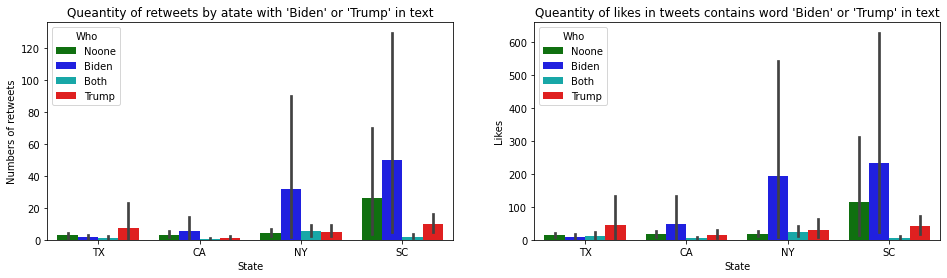

In [84]:
all_cities = df_ny.append([df_la,df_ho,df_wo],ignore_index = True)
all_cities=all_cities.sort_values("Date of creation")

key_words_biden = ['biden','joe','Biden','Joe']
key_words_trump = ['donald','trump','Donald','Trump']

all_cities['Who'] = ''
for i in range(len(all_cities)):
    text = all_cities['Text'][i]
    if any(word in text for word in key_words_trump) and not any(word in text for word in key_words_biden):
        all_cities.loc[i, 'Who'] = 'Trump'
    elif any(word in text for word in key_words_biden) and not any(word in text for word in key_words_trump):
        all_cities.loc[i, 'Who'] = 'Biden'
    elif any(word in text for word in key_words_biden) and any(word in text for word in key_words_trump):
        all_cities.loc[i, 'Who'] = 'Both'
    else:
        all_cities.loc[i, 'Who'] = 'Noone'
f, (ax1,ax2) = plt.subplots(1, 2,figsize=(16,4))   
sns.barplot(x='State',y='Numbers of retweets',hue = 'Who',data=all_cities,
            palette={'Trump':'r', 'Biden':'b', 'Noone':'g','Both':'c'}, ax = ax1)
  
sns.barplot(x='State',y='Likes',hue = 'Who',data=all_cities,
            palette={'Trump':'r', 'Biden':'b', 'Noone':'g','Both':'c'},ax = ax2)
ax1.set_title("Queantity of retweets by atate with 'Biden' or 'Trump' in text")
ax2.set_title("Queantity of likes in tweets contains word 'Biden' or 'Trump' in text")
plt.show()

<Figure size 936x216 with 0 Axes>

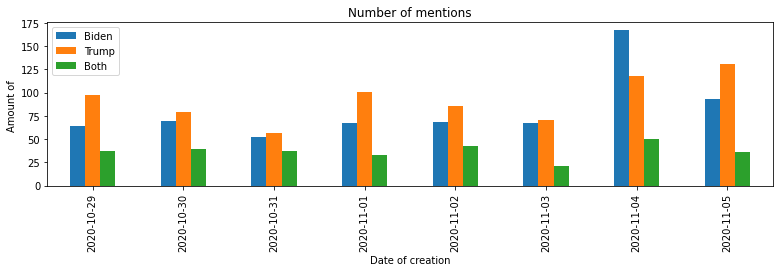

In [85]:
import matplotlib.pyplot as plt

date = ["2020-10-29","2020-10-30","2020-10-31","2020-11-01",
        "2020-11-02","2020-11-03","2020-11-04","2020-11-05","2020-11-06"]
biden_counter = {}
trump_counter = {}
noone_counter = {}
both_counter = {}
for day in date:
    for index in range(len(all_cities["Date of creation"])):
        if day in str(all_cities["Date of creation"][index]):
            if all_cities["Who"][index] == 'Biden':
                if day in biden_counter:
                    biden_counter[day]+=1
                else:
                    biden_counter[day] = 1
            elif all_cities["Who"][index] == 'Trump':
                if day in trump_counter:
                    trump_counter[day]+=1
                else:
                    trump_counter[day] = 1
            elif all_cities["Who"][index] == 'Noone':
                if day in noone_counter:
                    noone_counter[day]+=1
                else:
                    noone_counter[day] = 1
            elif all_cities["Who"][index] == 'Both':
                if day in both_counter:
                    both_counter[day]+=1
                else:
                    both_counter[day] = 1

df = pd.DataFrame({'Biden': pd.Series(biden_counter), 'Trump': pd.Series(trump_counter),'Both': pd.Series(both_counter)})

fig= plt.figure(figsize=(13,3))
df.plot.bar(figsize=(13,3))
plt.ylabel("Amount of ")
plt.xlabel("Date of creation")
plt.title("Number of mentions")
plt.show()

As we can see on the diagrams, the most commons tweets which were reetweeted in Washington and New York has word "Biden" inside. Likes are also popped up more often when the tweet is about Joe Biden. <br>
<br>
Second diagram shows the number of mentions in time during that week, we can see that during first 5 days users mentioned Biden arount 52 to 69 times per day, but during 04.11 it jumped to 167 mentions. It was the day after election when the Trumps votes were counted because as we known that the republicans usually are voting stationary.
During this day commissions were counting Biden votes and it was turned out that he is winning, that can be one of the reasons why the increase was around 250% in one day.

## Time series plot
By adding up the number of tweets over time, it can be seen that their number increases moderately over the period of these 8 days. 

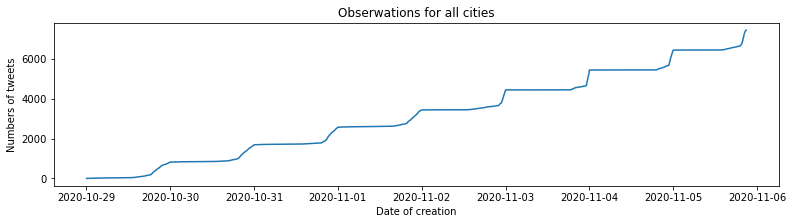

In [86]:
ylabel = "Numbers of tweets"

fig = plt.figure(figsize=(13,3))
counter = []
c = 1
sort=all_cities.sort_values("Date of creation")
for i in sort["Date of creation"]:
    counter.append(c)
    c+=1
plt.plot(sort["Date of creation"],counter)
plt.ylabel(ylabel)
plt.xlabel("Date of creation")
plt.title(f"Obserwations for all cities")
plt.show()

## Hashtags
One of the last part prepared by us will be analyze of hashtags, there are no doubt that the most famoust hashtag was #Election2020, at the graph we can see that tweets in which Joe Biden was mentioned were usually hashtags referring to his collaboration with future Ms. vice president Kamala Harris. 
<br>

Interestingly, when it comes to Trump, in the posts in which he was mentioned, you could also see hashtags with this lady. At the end we can see the hashtags for 'noone' and there is also the largest number of # Election2020, but the last two, which were relatively less, indicate the initial increase in hashtags related to the election results. 
<br>
We think that the currently downloaded data would change this order and #ElectionResults would be much earlier than the others.

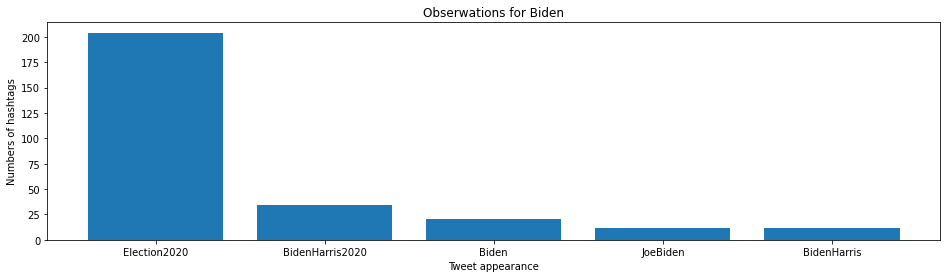

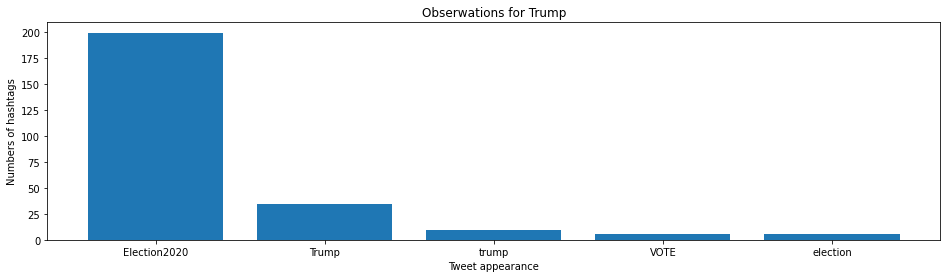

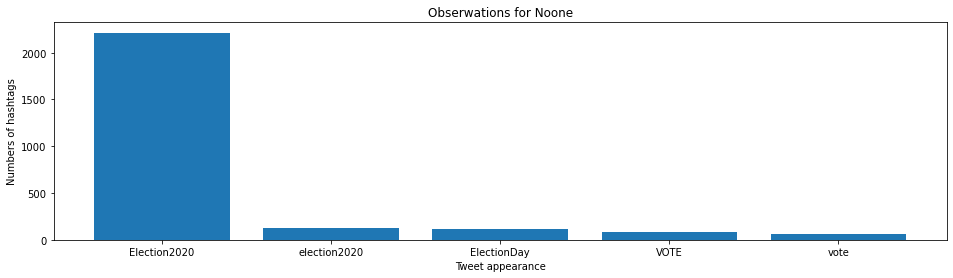

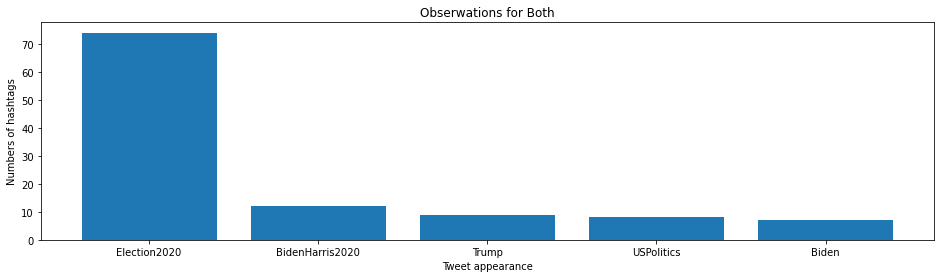

In [87]:
biden=all_cities[all_cities["Who"]=="Biden"]
trump=all_cities[all_cities["Who"]=="Trump"]
noone=all_cities[all_cities["Who"]=='Noone']
both=all_cities[all_cities["Who"]=='Both']

frames=[biden,trump,noone,both]
place_name=["Biden","Trump","Noone","Both"]

empty = []
for k in range(len(frames)):
    town = frames[k]
    city = place_name[k]
    ylabel = "Numbers of hashtags"

    fig = plt.figure(figsize=(16,4))

    n_row = len(ylabel)
    n_col = 1
    hashtags = {}
    for hs in town['Hashtags']:
        if hs == '':
            empty.append(hs)
        else:
            if hs in hashtags:
                hashtags[hs]+=1
            else:
                hashtags[hs]=1
    common_hashtags={}
    for i in range(5):
        key = max(hashtags, key=lambda k: hashtags[k])
        common_hashtags[key]=hashtags[key]
        del hashtags[key]
         
    plt.bar(list(range(len(common_hashtags))),list(sorted(common_hashtags.values(),reverse=True)))
    plt.ylabel(ylabel)
    plt.xlabel("Tweet appearance")
    plt.title(f"Obserwations for {city}")
    plt.xticks(list(range(len(common_hashtags))),common_hashtags.keys())
    plt.show()

## Tweets Sentiment

Next thing we would like to check is the sentiment of tweets connected with each of the candidates. It may vary between values of -1 (which means that the tweet has negative meaning) and +1 (which means that the tweet is rather positive). Values close to 0 indicates neutral form of tweet. We tested for each candidate what was the sentiment of tweets with their names used in text. Also we checked ho would behave tweets with both candidates included and none of them aswell.

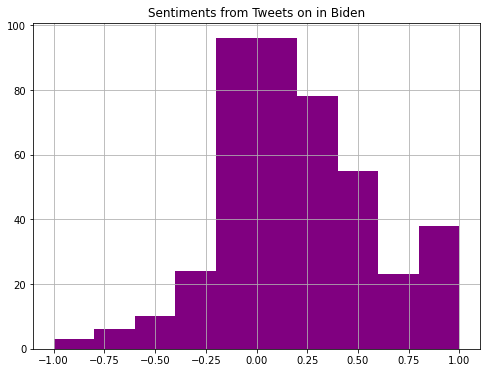

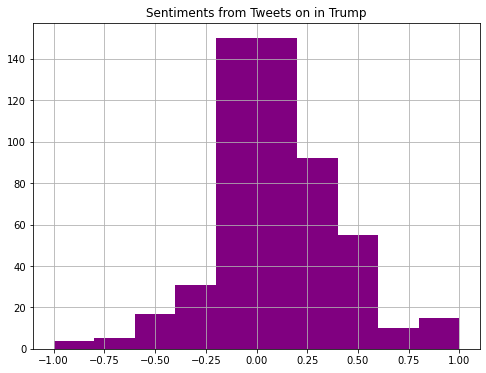

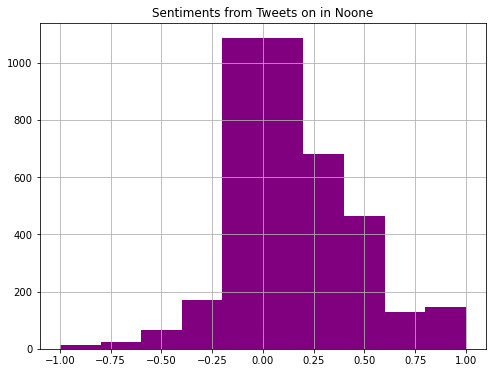

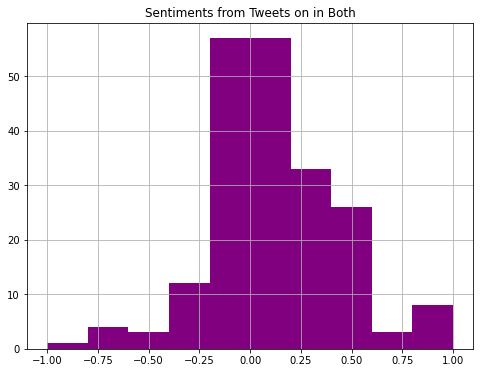

In [88]:
frames=[biden,trump,noone,both]
for k in range(len(frames)):
    frame=frames[k]
    city=place_name[k]
    fig, ax = plt.subplots(figsize=(8, 6))
    clear_df=frame[frame['Polarity'] != 0]
    # Plot histogram of the polarity values
    clear_df.hist(column='Polarity',bins=[-1, -0.8, -0.6, -0.4, -0.2, 0.2, 0.4, 0.6, 0.8, 1],
                 ax=ax,
                 color="purple")

    plt.title(f"Sentiments from Tweets on in {city}")
    plt.show()

As we can see, the results of each plot is similar, which means that the polarity of tweets does not depend much on their views. The only big difference is that Biden gets more positive tweets than Trump, while these tweets which include both of them seems to be more negative than others. In summary, we can see that twitter users prefer to stay neutral/cheer their candidate than blame their opponent.

## Sentiment over time

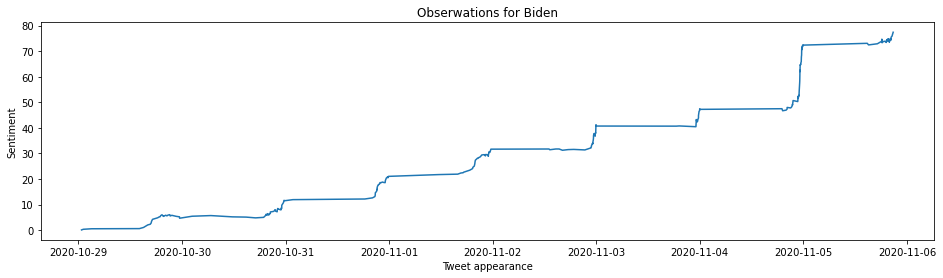

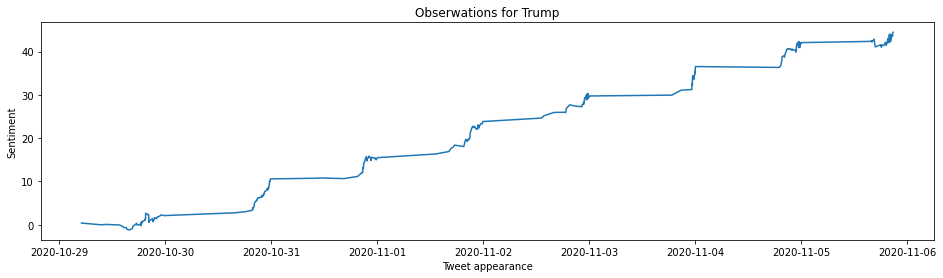

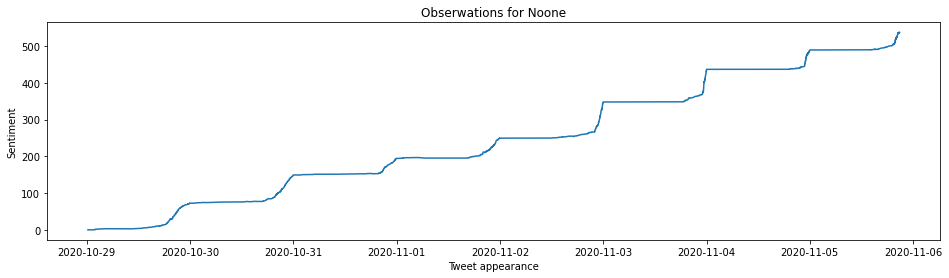

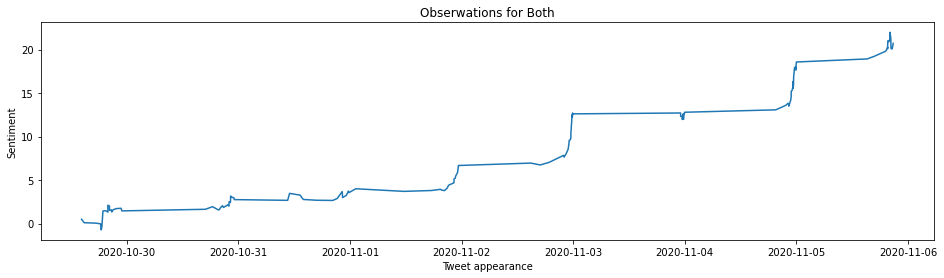

In [89]:
def count_sentiment(dataframe):
    sentiment_over_time=[]
    clear_df=dataframe[dataframe['Polarity'] != 0]
    for polar in clear_df['Polarity']:
        if sentiment_over_time==[]:
            sentiment_over_time.append(polar)
        else:
            sentiment_over_time.append(sentiment_over_time[-1]+polar)
    return clear_df,sentiment_over_time

for k in range(len(frames)):
    fig = plt.figure(figsize=(16,4))
    city=place_name[k]
    [df,sent]=count_sentiment(frames[k])
    plt.plot(sorted(df['Date of creation']),sent)
    plt.ylabel("Sentiment")
    plt.xlabel("Tweet appearance")
    plt.title(f"Obserwations for {city}")
    plt.show()

Another thing correlated to sentiment that we can check is how does sentiment behaves in time. As shown above, it is mostly positive valued, so we may expect that it will increase over time. As we can see plots does not provide to many interesting information, but we can come to 3 conclusions: First, something positive happend for Biden on 5th of november, which granted him a lot of positive tweets. Second, Trump had a lot of disturbance over time, which means tweets with his name are more mixed in case of sentiment. Third, when it comes to tweets containing both candidates, it started from rather negative side, being low at the first day and slowly granting poarity.

In [91]:
import folium as folium
NY = [40.714353,-74.00597299999998] #Four main cities in witch we will be shearch the tweets
LA = [34.0207289,-118.6926019]
TX = [29.7632800,-95.3632700]
WA = [38.8972578,-77.0345083]
m=folium.Map(location=[38,-100],zoom_start=4)
cities=['NY','CA','TX','SC']
whos=['Biden','Both','Trump']
for city in cities:
    dic={'Biden':0,'Both':0,'Trump':0}
    state=all_cities[all_cities['State']==city]
    for who in state['Who']:
        if who!='Noone':
            dic[who]+=1
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)
    ax.bar(list(range(len(dic))),list((dic.values())),color=['r', 'b', 'g'],width=1)
    ax.axis('off')
    plt.savefig(f'Pictures/{city}.png',transparent=True)
    plt.close()
    
iconNY=folium.features.CustomIcon('Pictures/NY.png',icon_size=(60,60))
folium.Marker(location=NY,icon=iconNY).add_to(m)
iconLA=folium.features.CustomIcon('Pictures/CA.png',icon_size=(60,60))
folium.Marker(location=LA,icon=iconLA).add_to(m)
iconTX=folium.features.CustomIcon('Pictures/TX.png',icon_size=(60,60))
folium.Marker(location=TX,icon=iconTX).add_to(m)
iconWA=folium.features.CustomIcon('Pictures/SC.png',icon_size=(60,60))
folium.Marker(location=WA,icon=iconWA).add_to(m)

plt.rcParams.update({'font.size': 30})
fig, ax = plt.subplots()

y_pos = np.arange(len(whos))

ax.barh(y_pos, [1,1,1],color=['r','b','g'])
ax.text(0.4,1.9,'Biden',color='w')
ax.text(0.4,0.9,'Both',color='w')
ax.text(0.4,-0.1,'Trump',color='w')
ax.axis('off') # labels read top-to-bottom


plt.savefig('Pictures/legend.png')
iconlegend=folium.features.CustomIcon('Pictures/legend.png',icon_size=(200,200))
folium.Marker(location=[26,-133],icon=iconlegend).add_to(m)
plt.close()
m

As you can see, the map is unfortunately not displayed, but by using the webdriver from the selenium library, we were able to convert the folium object to a map in .html format and then modify the html to an image in .png format, such as displayed below. The quality of this is better when you will open the .html file out of Jupyter Notebook.

In [94]:
#It is commented because each of you can have other path to the webdriver file
import time
from selenium import webdriver

delay=5
fn='Pictures/map.html'
tmpurl='file://{path}/{mapfile}'.format(path=os.getcwd(),mapfile=fn)
m.save(fn)

# browser = webdriver.Chrome('/usr/local/bin/chromedriver')
# browser.get(tmpurl)
# #Give the map tiles some time to load
# time.sleep(delay)
# browser.save_screenshot('Pictures/map.png')
# browser.quit()

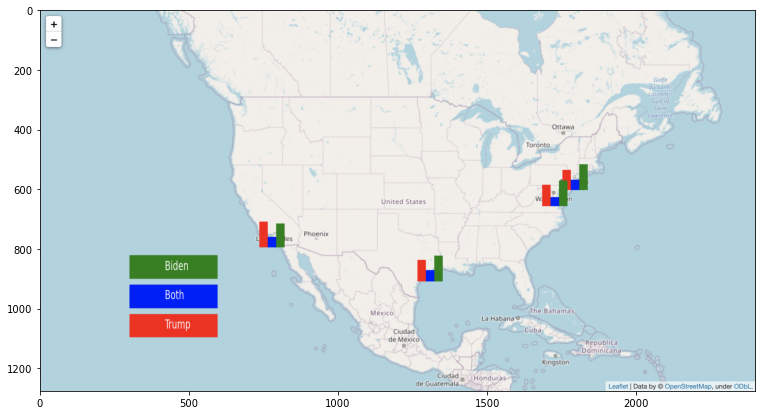

In [115]:
import matplotlib.image as mpimg
img = mpimg.imread('Pictures/map.png')
plt.figure(figsize=(17,7))  
plt.imshow(img)
plt.show()

Last thing we would like to do, is to show something on a map. We decided that the most interesting thing that we could show is number of tweets connetcted with each candidate for each state. As we can se only Los Angeles and surroundings have more interest in Trump than in Biden, but for each city the shape of plots is similar, which means that place does not have big impact in tweets mentions.

# Task 2

Here we decided to prepare statistical analysis for tweets from the accounts of the two largest political parties currently in the Polish parliament. One of them is the right-wing PIS party, the other belongs to the central stream and is the PO.
<br>
As before we used tweepy library to collect the data and save them into the .json files.

In [ ]:
files = ["PO","PIS"]
users = ["@Platforma_org","@pisorgpl"]
for i in range(0,len(users)):
    tweet_list = []
    tweeters = tw.Cursor(api.user_timeline, screen_name=users[i], tweet_mode='extended',include_rts = False,since="2020-10-29",until = "2020-11-05" ).items()
    for tweet in tweeters:
        tweet_list.append(tweet._json)
    file = open(f'{users[i]}.json', 'wb')

    print(f"Writing tweet objects to JSON for {files[i]} please wait...")   
    with open(f'{files[i]}.json', 'w', encoding='utf8') as file:
        json.dump(tweet_list,file)


In [98]:
with open("Twitter_data/PO.json") as json_file:
    data_po = json.load(json_file)
with open("Twitter_data/PIS.json") as json_file:
    data_pis = json.load(json_file)
    
data = [data_po,data_pis]


df_person = []


for k in range(0,2):
    person = data[k]
    city = []
    text = []
    user = []
    created = []
    favorite = []
    retweet = []
    hashtags = []
    sentiments = []
    for tweet in person:
        created.append(tweet['created_at']) #Creation columns
        favorite.append(tweet['favorite_count'])
        retweet.append(tweet['retweet_count'])
        city.append(tweet['user']['location'])
        text.append(tweet['full_text'])
        user.append(tweet['user']['name'])  
        hstg=tweet['entities']['hashtags']
        if hstg!=[]:
            hashtags.append(hstg[0]['text'])
        else:
            hashtags.append('')
        sentiments.append(TextBlob(tweet['full_text']).polarity)
    df_person.append(pd.DataFrame(list(zip(user,created,retweet, city,
            text,hashtags,sentiments,favorite)),columns=['User','Date of creation','Numbers of retweets','City','Text','Hashtags','Polarity','Likes']))  

   
    
df_po = DataFrame(df_person[0]) #data for PO
df_pis = DataFrame(df_person[1]) #data for PIS
df_po = clean_datatime(df_po)
df_pis = clean_datatime(df_pis)


As you can see below, our tables contains name of the usear, here it will be "PlatformaObywatelska" or "Prawo i Sprawiedliwość", date of tweet creation, number of retweets, city, whole text of the tweet, polarity and likes. The last two column were created for this task only, because that colums will help us create charts with time of the tweet creation.

In [99]:
df_po

,User,Date of creation,Numbers of retweets,City,Text,Hashtags,Polarity,Likes,Just date,Just time
0,PlatformaObywatelska,2020-11-12 15:16:27+00:00,9,Polska,🖥 Dziś o 19:20 przewodniczący @bbudka będzie g...,POwmediach,0.0,22,2020-11-12,15:16:27
1,PlatformaObywatelska,2020-11-12 14:52:46+00:00,25,Polska,Warunki przyjęcia do Szpitala Narodowego: \n📍l...,,0.0,88,2020-11-12,14:52:46
2,PlatformaObywatelska,2020-11-12 12:34:51+00:00,0,Polska,🔴NA ŻYWO: Konferencja prasowa @AGajewska i @Ml...,,0.0,10,2020-11-12,12:34:51
3,PlatformaObywatelska,2020-11-12 12:20:11+00:00,4,Polska,🎥Dziś o godz. 13:30 przed Empikiem w Warszawie...,,0.0,12,2020-11-12,12:20:11
4,PlatformaObywatelska,2020-11-12 12:14:00+00:00,16,Polska,Przewodniczący @bbudka: Rząd walczy z kryzysem...,,0.0,104,2020-11-12,12:14:00
...,...,...,...,...,...,...,...,...,...,...
115,PlatformaObywatelska,2020-10-29 10:06:32+00:00,16,Polska,.@TomaszSiemoniak: Jarosław Kaczyński od kilku...,WybórNieZakaz,0.0,109,2020-10-29,10:06:32
116,PlatformaObywatelska,2020-10-29 10:05:35+00:00,17,Polska,.@MWielichowska: Kaczyński mobilizuje bandytów...,WybórNieZakaz,0.0,53,2020-10-29,10:05:35
117,PlatformaObywatelska,2020-10-29 10:04:21+00:00,15,Polska,.@MWielichowska: Dziś Kaczyński zachęca bandyc...,WybórNieZakaz,0.0,63,2020-10-29,10:04:21
118,PlatformaObywatelska,2020-10-29 10:03:16+00:00,12,Polska,.@MWielichowska: Jarosław Kaczyński wzniecił p...,WybórNieZakaz,0.0,54,2020-10-29,10:03:16


In [100]:
df_pis

,User,Date of creation,Numbers of retweets,City,Text,Hashtags,Polarity,Likes,Just date,Just time
0,Prawo i Sprawiedliwość,2020-11-12 14:51:10+00:00,33,Poland,.@RzecznikPiS dla #PAP: Sprawa wydarzeń podcza...,PAP,0.0,117,2020-11-12,14:51:10
1,Prawo i Sprawiedliwość,2020-11-12 13:37:50+00:00,5,Poland,Politycy #PiS dziś (12.11) w mediach:\n15:33 @...,PiS,0.0,11,2020-11-12,13:37:50
2,Prawo i Sprawiedliwość,2020-11-12 10:34:00+00:00,11,Poland,"Poseł #PiS, @RzecznikPiS A. #Czerwińska w #War...",PiS,0.0,33,2020-11-12,10:34:00
3,Prawo i Sprawiedliwość,2020-11-12 10:32:24+00:00,9,Poland,"Poseł #PiS, @RzecznikPiS A. #Czerwińska w #War...",PiS,0.0,29,2020-11-12,10:32:24
4,Prawo i Sprawiedliwość,2020-11-12 10:28:38+00:00,7,Poland,Minister @MRiPS_GOV_PL @MarlenaMalag w #Warsza...,Warszawa,0.0,30,2020-11-12,10:28:38
...,...,...,...,...,...,...,...,...,...,...
210,Prawo i Sprawiedliwość,2020-10-29 07:23:58+00:00,30,Poland,Rzecznik #Rząd @PiotrMuller w @KwadransPolit: ...,Rząd,0.0,196,2020-10-29,07:23:58
211,Prawo i Sprawiedliwość,2020-10-29 07:21:43+00:00,7,Poland,Rzecznik #Rząd @PiotrMuller w @KwadransPolit: ...,Rząd,0.0,22,2020-10-29,07:21:43
212,Prawo i Sprawiedliwość,2020-10-29 07:17:43+00:00,19,Poland,Rzecznik #Rząd @PiotrMuller w @KwadransPolit: ...,Rząd,0.0,81,2020-10-29,07:17:43
213,Prawo i Sprawiedliwość,2020-10-29 06:23:52+00:00,35,Poland,"Przewodniczący KW #PiS, Poseł K. #Sobolewski w...",PiS,0.0,139,2020-10-29,06:23:52


## Common words found in tweets

In the code below we used our function "count_most_comon", which is counting presents of the most comon words in tweets, if stopwords will be equal to 1, the function automatically dump from the table Polish stopwords which are in the file stopwords_tweeter.txt. This .txt file contains not only Polish common stopwords but the shortcuts that where mainly used by this two parties in tweeter, e.g. stopword = dzięki, tweeter_stopword = dzki.


In [101]:
clean_po = count_most_common(df_po,stopwords = 1)
clean_pis = count_most_common(df_pis,stopwords = 1)

df_clean_pis = pd.DataFrame(clean_pis,columns=['words', 'count'])
df_clean_po = pd.DataFrame(clean_po,columns=['words', 'count'])


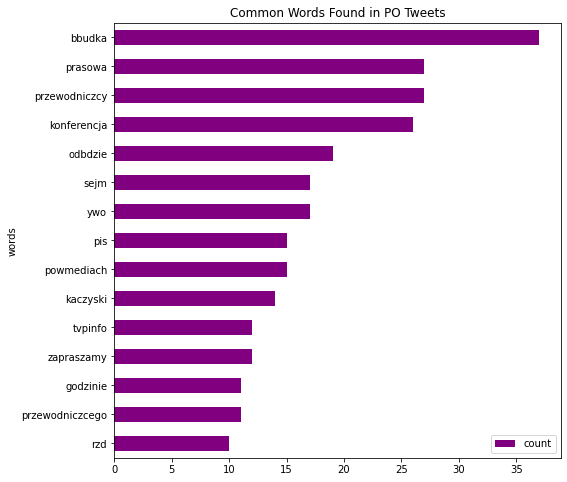

In [102]:
plt.rcParams.update({'font.size': 10})
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
df_clean_po.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Common Words Found in PO Tweets")

plt.show()

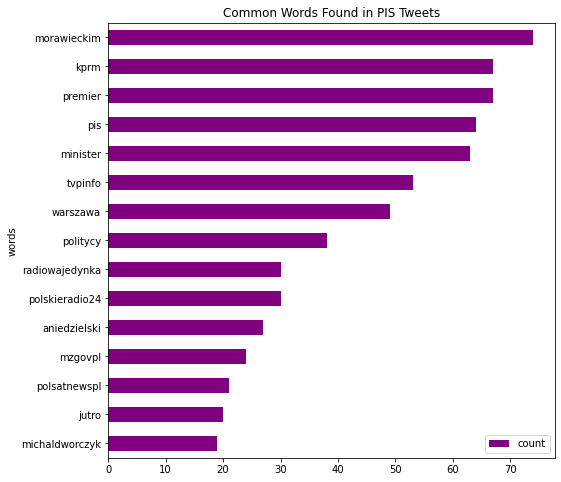

In [103]:
fig, ax = plt.subplots(figsize=(8, 8))

df_clean_pis.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Common Words Found in PIS Tweets")

plt.show()

As we can se at the charts above, in both of this group the most common word was the name of their head office. For PO it was Borys Budka and for PIS it was Mateusz Morawiecki. For PO athe the second and third place were informations about press conference, for the other group it was a mention of the Chancellery of the Prime Minister of Ministers and about Prime Minister. <br>

What we managed to conclude is that mostly both parties write posts on topics in which there are words related to the party that currently rules in Poland - PIS. On the other hand, the conclusions that we had to take into account at the stage of writing the code are that both parties, in order to write as much as possible in their posts, cut off the endings of words or their initial letters, e.g. "ycie"

## Number of retweets and likes

In [104]:
result = pd.concat([df_po,df_pis]) #create one big table with all results
table = result.groupby(['User','Just date','Likes'])['Numbers of retweets'].sum().reset_index() #grouping by number of retweets

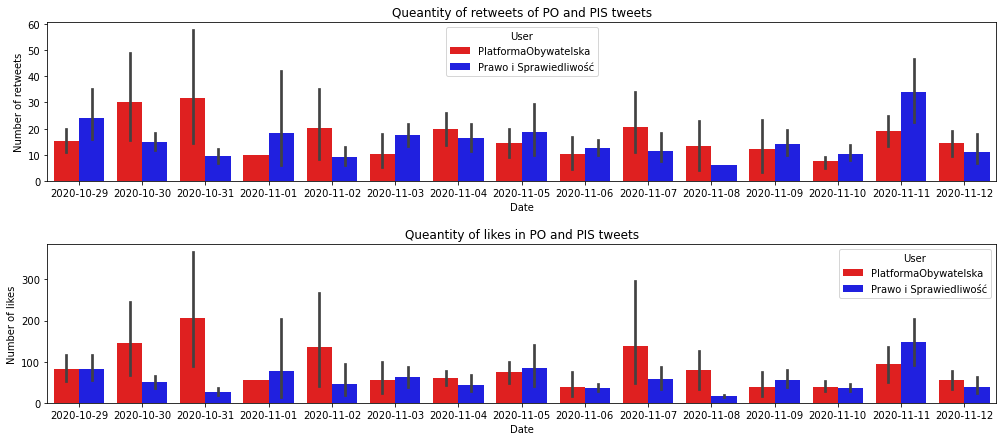

In [105]:
f, (ax1,ax2) = plt.subplots(2, 1,figsize=(17,7))   
sns.barplot(x='Just date',y='Numbers of retweets',hue = 'User',data=table,
            palette={'PlatformaObywatelska':'r', 'Prawo i Sprawiedliwość':'b'}, ax = ax1)
  
sns.barplot(x='Just date',y='Likes',hue = 'User',data=table,
            palette={'PlatformaObywatelska':'r', 'Prawo i Sprawiedliwość':'b'}, ax = ax2)
ax1.set_title("Queantity of retweets of PO and PIS tweets")
ax2.set_title("Queantity of likes in PO and PIS tweets")
plt.subplots_adjust(hspace = 0.4)
ax1.set_xlabel("Date")
ax2.set_xlabel("Date")
ax1.set_ylabel("Number of retweets")
ax2.set_ylabel("Number of likes")
ax.set_title("Common Words Found in PIS Tweets")
plt.show()

From this charts we can find out that number of retweets was bigger for Platforma Obywatelska during last week of October. The majority of the numbers are similar for both parties, only on November 11 there was a significant difference, PIS retweets prevailed, it was probably caused by the Independence March, during which units from the ruling party appeared.

<br>
On the second plot we can see that PO usually gets more likes under its tweets. This may be explained by the fact that most of the people who vote for PIS do not have a tweeter account.

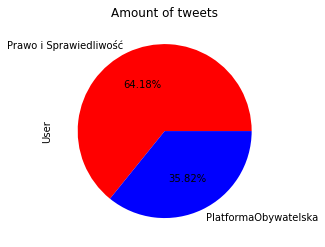

In [106]:
result.User.value_counts().plot(kind='pie',autopct='%1.2f%%',colors = ['red','blue'])
plt.title('Amount of tweets')
plt.show()


Here we prepare pie plot with the amount of all the tweets from 29.10 to 12.11, as it is shown, there is a diference betweeen number of created tweets.

In [107]:
time1 = pd.DataFrame(df_po,columns=['User','Just time'])
time2 = pd.DataFrame(df_pis,columns=['User','Just time'])

## Tweets by hour

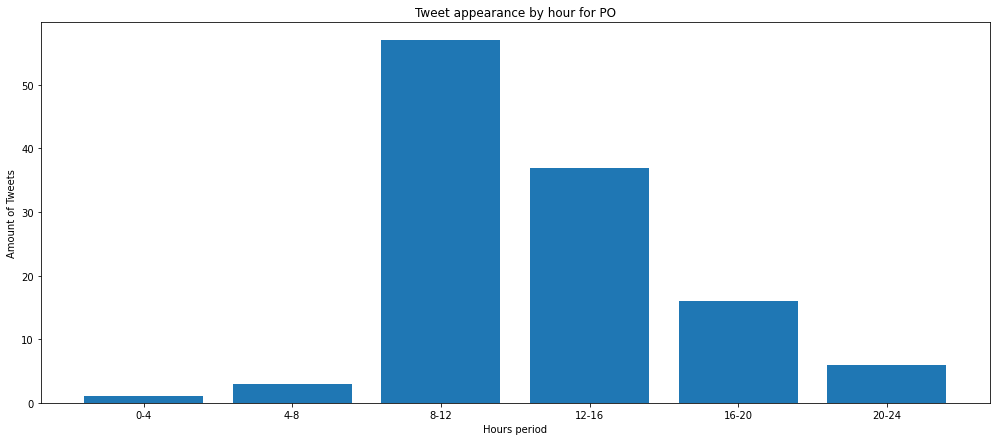

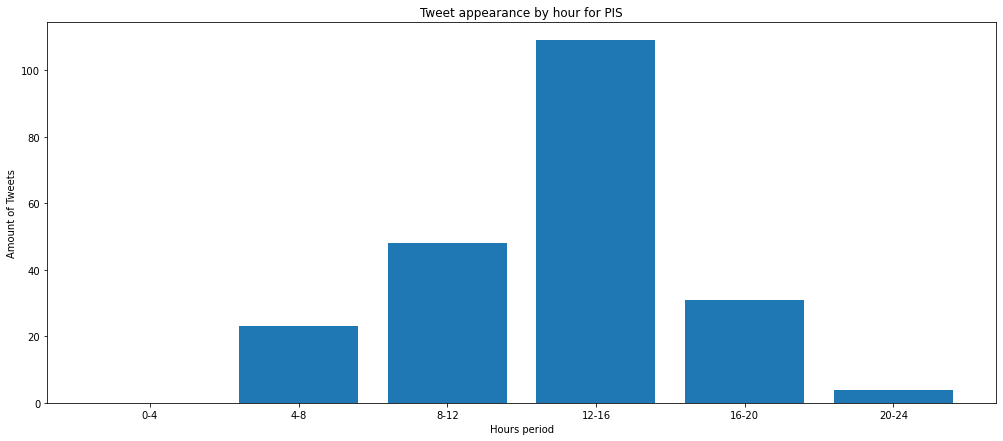

In [108]:
times1={}
times2={}
hours=[0,4,8,12,16,20,24]
for hour in range(6):
    times1[str(hours[hour])+'-'+str(hours[hour+1])]=sum(time1['Just time']<=datetime.time(hours[hour+1]-1,59,59))-sum(time1['Just time']<datetime.time(hours[hour],0,0))
    times2[str(hours[hour])+'-'+str(hours[hour+1])]=sum(time2['Just time']<=datetime.time(hours[hour+1]-1,59,59))-sum(time2['Just time']<datetime.time(hours[hour],0,0))

f= plt.subplots(figsize=(17,7))      
plt.bar(list(range(len(times1))),list(times1.values()))
plt.ylabel('Amount of Tweets')
plt.xlabel("Hours period")
plt.title("Tweet appearance by hour for PO")
plt.xticks(list(range(len(times1))),times1.keys())
plt.show()

f= plt.subplots(figsize=(17,7))      
plt.bar(list(range(len(times2))),list(times2.values()))
plt.ylabel('Amount of Tweets')
plt.xlabel("Hours period")
plt.title("Tweet appearance by hour for PIS")
plt.xticks(list(range(len(times2))),times2.keys())
plt.show()


In this part we managed to prepare barplots which can show during which part of the day our political parties are creating post and share them with the others. As it is shown the higher amount of tweets is from 8 a.m. to 4 p.m. . We think that it is natural because sejm deliberations are usually held during the day, therefore all information that will be agreed is immediately available on the tweeter.